# Flower Classifier with VGG16

### Loading VGG model

In [2]:
from tensorflow.keras.applications import VGG16

img_rows = 224
img_cols = 224

vgg16 = VGG16(weights = "imagenet",
              include_top = False,
              input_shape = (img_rows, img_cols,3))

In [3]:
for i, layer in enumerate (vgg16.layers):
    print(str(i)+ " "+layer.__class__.__name__, layer.trainable)

0 InputLayer True
1 Conv2D True
2 Conv2D True
3 MaxPooling2D True
4 Conv2D True
5 Conv2D True
6 MaxPooling2D True
7 Conv2D True
8 Conv2D True
9 Conv2D True
10 MaxPooling2D True
11 Conv2D True
12 Conv2D True
13 Conv2D True
14 MaxPooling2D True
15 Conv2D True
16 Conv2D True
17 Conv2D True
18 MaxPooling2D True


In [5]:
## Freeze all layer except top 4

for layer in vgg16.layers:
    layer.trainable = False
    
for i , layer in enumerate (vgg16.layers):
    print(str(i) + " "+ layer.__class__.__name__,layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


# Make a function to get back the FC Head

In [6]:
def addTopmodel(bottom_model, num_classes, D = 256):
    ## D= Dense layer
    
    top_model = bottom_model.output
    top_model = Flatten(name = "flatten")(top_model)
    top_model = Dense(D, activation = "relu")(top_model)
    top_model = Dropout((0.3))(top_model)
    top_model = Dense(num_classes, activation = "softmax")(top_model)
    
    return top_model



# Add our FC Head back onto VGG

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

In [8]:
num_classes = 17

FC_Head = addTopmodel(vgg16, num_classes, 128)

model = Model(inputs = vgg16.input, outputs = FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

2021-09-23 03:22:33.281294: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 12845056 exceeds 10% of free system memory.
2021-09-23 03:22:33.303157: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 12845056 exceeds 10% of free system memory.
2021-09-23 03:22:33.309718: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 12845056 exceeds 10% of free system memory.


# Loading Flower Dataset

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = "./Classifier/17_flowers/train"
validation_data_dir = "./Classifier/17_flowers/validation"

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = "nearest")

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_batchsize = 16
val_batchsize = 10

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size = (img_rows, img_cols),
                                                    batch_size = train_batchsize,
                                                    class_mode = "categorical")

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                              target_size = (img_rows, img_cols),
                                                              batch_size = val_batchsize,
                                                              class_mode = "categorical")

Found 1190 images belonging to 17 classes.
Found 170 images belonging to 17 classes.


# Training Top Layers 

In [12]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("Flower_classifier_vgg16.h5",
                             monitor = "val_loss",
                             mode = "min",
                             save_best_only = True,
                             verbose = 1)

earlystop = EarlyStopping(monitor = "val_loss",
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [checkpoint, earlystop]

model.compile(loss = "categorical_crossentropy",
              optimizer = RMSprop(lr = 0.001),
              metrics = ["accuracy"])

nb_train_samples = 1190
nb_val_samples = 170
epochs = 3
batch_size = 16


In [13]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = nb_train_samples//batch_size,
                              epochs = epochs,
                              callbacks = callbacks,
                              validation_data = validation_generator,
                              validation_steps = nb_val_samples//batch_size)

model.save("flowers_classifier_vgg16.h5")

/home/robin/anaconda3/envs/robin/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-09-23 03:44:17.071299: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-23 03:44:17.162138: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2194775000 Hz


Epoch 1/3


2021-09-23 03:44:17.859640: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 12845056 exceeds 10% of free system memory.
2021-09-23 03:44:19.099046: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 12845056 exceeds 10% of free system memory.


74/74 [==============================] - 562s 8s/step - loss: 3.3877 - accuracy: 0.1363 - val_loss: 2.4897 - val_accuracy: 0.1100

Epoch 00001: val_loss improved from inf to 2.48973, saving model to Flower_classifier_vgg16.h5
Epoch 2/3
74/74 [==============================] - 614s 8s/step - loss: 2.2405 - accuracy: 0.2658 - val_loss: 1.5877 - val_accuracy: 0.5700

Epoch 00002: val_loss improved from 2.48973 to 1.58773, saving model to Flower_classifier_vgg16.h5
Epoch 3/3
74/74 [==============================] - 566s 8s/step - loss: 1.9393 - accuracy: 0.3739 - val_loss: 1.1582 - val_accuracy: 0.7000

Epoch 00003: val_loss improved from 1.58773 to 1.15816, saving model to Flower_classifier_vgg16.h5


# Load the model

In [3]:
from tensorflow.keras.models import load_model

clf = load_model("flowers_classifier_vgg16.h5")

# Improving the model performance

In [2]:
from tensorflow.keras.applications import VGG16

In [4]:
#Resizing the image size

img_rows = 64
img_cols = 64

vgg16 = VGG16(weights = "imagenet",
              include_top = False,
              input_shape = (img_rows, img_cols, 3))

for layer in vgg16.layers:
    layer.trainable = False
    
for i, layer in enumerate(vgg16.layers):
    print(str(i)+" "+layer.__class__.__name__,layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


# Create New model using image size 64x64

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [8]:
train_data_dir = "./Classifier/17_flowers/train"
validation_data_dir = "./Classifier/17_flowers/validation"


train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = "nearest")

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_batchsize = 32
val_batchsize = 10

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size = (img_rows, img_cols),
                                                    batch_size = train_batchsize,
                                                    class_mode = "categorical")

validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                              target_size = (img_rows, img_cols),
                                                              batch_size = val_batchsize,
                                                              class_mode = "categorical",
                                                              shuffle = False)
#number of classes in flower dataset
num_classes = 17

FC_Head = addTopmodel(vgg16, num_classes)

model = Model(inputs = vgg16.input, outputs = FC_Head)

print(model.summary())

Found 1190 images belonging to 17 classes.
Found 170 images belonging to 17 classes.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
__________________________________________

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("flower_clf_vgg16_64.h5",
                             monitor = "val_loss",
                             mode = "min",
                             save_best_only = True,
                             verbose = 1)

earlystop = EarlyStopping(monitor = "val_loss",
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = "val_loss",
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.00001)

callbacks = [checkpoint, earlystop, reduce_lr]


model.compile(loss = "categorical_crossentropy",
              optimizer = RMSprop(lr = 0.0001),
              metrics = ["accuracy"])

nb_train_samples = 1190
nb_val_samples = 170
epochs = 25
batch_size = 32

history = model.fit_generator(train_generator,
                              steps_per_epoch = nb_train_samples//batch_size,
                              epochs = epochs,
                              callbacks = callbacks,
                              validation_data = validation_generator,
                              validation_steps = nb_val_samples//batch_size)

model.save("flower_clf_vgg16_64.h5")

Epoch 1/25
37/37 [==============================] - 43s 1s/step - loss: 1.1464 - accuracy: 0.6425 - val_loss: 1.2664 - val_accuracy: 0.6000

Epoch 00001: val_loss improved from inf to 1.26638, saving model to flower_clf_vgg16_64.h5
Epoch 2/25
37/37 [==============================] - 45s 1s/step - loss: 1.0869 - accuracy: 0.6857 - val_loss: 1.3566 - val_accuracy: 0.5600

Epoch 00002: val_loss did not improve from 1.26638
Epoch 3/25
37/37 [==============================] - 46s 1s/step - loss: 1.0709 - accuracy: 0.6779 - val_loss: 1.2435 - val_accuracy: 0.6200

Epoch 00003: val_loss improved from 1.26638 to 1.24353, saving model to flower_clf_vgg16_64.h5
Epoch 4/25
37/37 [==============================] - 47s 1s/step - loss: 1.0450 - accuracy: 0.6839 - val_loss: 1.3616 - val_accuracy: 0.5400

Epoch 00004: val_loss did not improve from 1.24353
Epoch 5/25
37/37 [==============================] - 47s 1s/step - loss: 1.0370 - accuracy: 0.6943 - val_loss: 1.3299 - val_accuracy: 0.5600

Epoch 0

# Plotting the Accuracy and loss

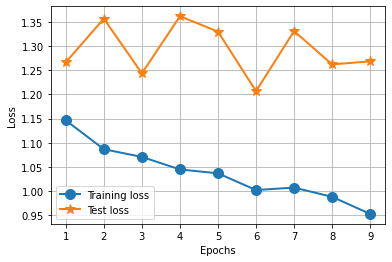

In [14]:
##plotting the loss Chart

import matplotlib.pyplot as plt
import numpy as np

history_dict = history.history

loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values)+1)

line1 = plt.plot(epochs, loss_values, label = "Training loss")
line2 = plt.plot(epochs, val_loss_values, label = "Test loss")

plt.setp(line1, linewidth = 2.0, marker = "o", markersize = 10.0)
plt.setp(line2, linewidth = 2.0, marker = "*", markersize = 10.0)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid("True")
plt.legend()
plt.show()

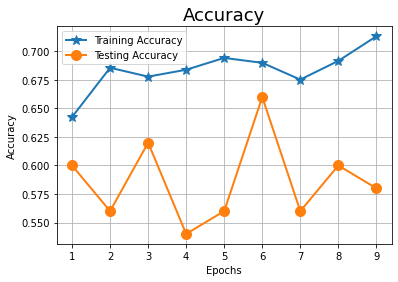

In [15]:
#plotting Accuracy

acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]

epochs = range(1,len(acc_values)+1)

line1 = plt.plot(epochs, acc_values, label = "Training Accuracy")
line2 = plt.plot(epochs, val_acc_values, label = "Testing Accuracy")

plt.setp(line1, linewidth = 2, marker = "*", markersize = 10)
plt.setp(line2, linewidth = 2, marker = "o", markersize = 10)
plt.title("Accuracy",fontsize = 18)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# Confusion Matrix and Classification Report

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

In [23]:
batch_size = 10


Y_pred = model.predict_generator(validation_generator, nb_val_samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis = 1)

print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred))

print("Classification Report")
#target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred))

Confusion Matrix
[[5 0 0 0 3 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 9 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 2 0 0 0 0 0 1 0 0 0]
 [1 0 2 5 0 0 0 0 0 0 0 0 0 0 1 0 1]
 [2 0 1 0 7 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 3 1 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 9 0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 9 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 9 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 9 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 2 4 0 1 0 0 0 1]
 [0 2 0 0 0 0 0 0 0 1 0 6 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 1 0 8 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 7 1 0]
 [1 0 0 2 0 2 0 1 0 0 0 0 0 0 1 2 1]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 8]]
Classification Report
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       0.56      0.90      0.69        10
           2       0.58      0.70      0.64        10
           3       0.71      0.50      0.59        10
           4       0.58      0.70      0.64        10
      